# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
using_colab = False

In [2]:

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_2_boxes(box1,box2,ax):
    x0, y0 = box1[0], box1[1]
    w, h = box1[2] - box1[0], box1[3] - box1[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    x0, y0 = box2[0], box2[1]
    w, h = box2[2] - box2[0], box2[3] - box2[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=2))


# Download model checkpoint
The checkpoint is 2.39GB, takes a few minutes for most bandwidths

In [5]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filepath = "sam_vit_h_4b8939.pth"

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filepath, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

Checkpoint file already exists. Skipping download.


In [6]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Chest X-ray Dataset

In [7]:
import os
from torchvision.datasets.utils import download_url

In [8]:
# Mount Google drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL2022')
except:
    print('Google drive not mounted')

Google drive not mounted


In [9]:
# If you are getting a download error below, comment in the following lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

Using existing ./datasets\lung_field_dataset.npz


In [11]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

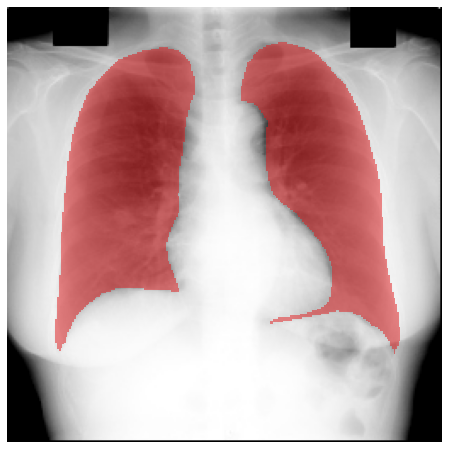

In [12]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

# TODO:
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

# YOUR CODE HERE

x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train)) *255
x_train = np.repeat(x_train, 3, axis=-1)
x_train = x_train.astype(np.uint8)


x_val = (x_val - np.min(x_val)) / (np.max(x_val) - np.min(x_val)) *255
x_val = np.repeat(x_val, 3, axis=-1)
x_val = x_val.astype(np.uint8)

x_test = (x_test - np.min(x_test)) / (np.max(x_test) - np.min(x_test)) *255
x_test = np.repeat(x_test, 3, axis=-1)
x_test = x_test.astype(np.uint8)


# Squeeze the single channel from the masks
y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)
y_test = np.squeeze(y_test)

# Convert data type to uint8
y_train = y_train.astype(np.uint8)
y_val = y_val.astype(np.uint8)
y_test = y_test.astype(np.uint8)


# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[1], y_train[1])
plt.show()

# Single Example image

Let's try to run SAM on a single example image

In [17]:
example_img, example_mask = x_train[0], y_train[0]

input_points = np.array([[70,170],[200,170],[80,60],[180,60]])
input_label = np.array([1,1,1,1])

example_img.shape

(256, 256, 3)

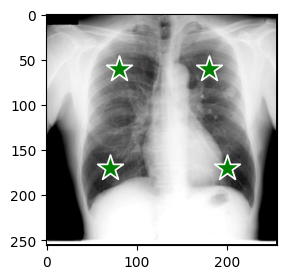

In [18]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca()) # You may also use other prompt methods!
plt.axis('on')
plt.show()

In [19]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

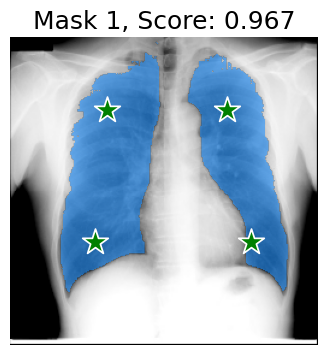

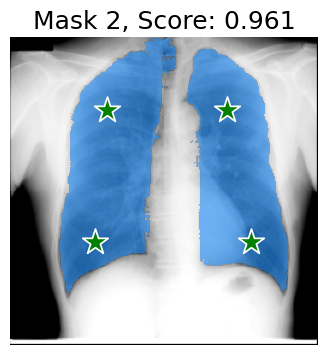

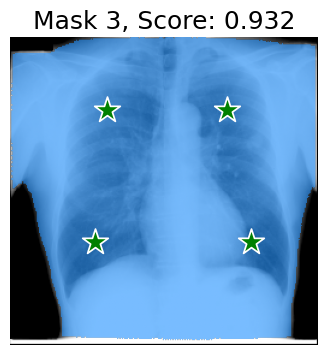

In [20]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Evaluation loop

In [21]:
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

In [23]:
import torchmetrics
f1 = torchmetrics.F1Score(task="binary")

f1_scores = []

for img, mask_gt in zip(x_val, y_val):
    predictor.set_image(img)
    mask_pred, scores, logits = predictor.predict(input_points,input_label, multimask_output=True)
    # Find the index of the dimension with the highest score
    scores_tensor = torch.from_numpy(scores)
    max_score_index = torch.argmax(scores_tensor)

    # Select the corresponding mask prediction
    mask_pred = mask_pred[max_score_index]


    # Compute F1 score
    f1_score = f1(torch.from_numpy(mask_pred), torch.from_numpy(mask_gt))
    f1_scores.append(f1_score.item())

mean_f1 = sum(f1_scores) / len(f1_scores)
std_f1 = np.std(f1_scores)

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

Mean F1 score: 0.6633
Standard deviation: 0.1915


# Using Bounding Boxes from GT segmentations as Prompt

In [13]:
def generate_boxes(data):
    boxes = []
    for mask in data:
        # Find the coordinates of the pixels with value 1 for the first lung so before the middle of the image
        coords = np.argwhere(mask == 1)
        #take the first half of the image
        coords_1 = coords[coords[:,1] <= 128]

        coords_2 = coords[coords[:,1] >= 128]

        # Find the minimum and maximum coordinates
        min_y_1, min_x_1 = coords_1.min(axis=0)
        max_y_1, max_x_1 = coords_1.max(axis=0)

        min_y_2, min_x_2 = coords_2.min(axis=0)
        max_y_2, max_x_2 = coords_2.max(axis=0)
        # Create the bounding boxes
        box_1 = np.array([min_x_1, min_y_1, max_x_1, max_y_1])
        box_2 = np.array([min_x_2, min_y_2, max_x_2, max_y_2])
        boxes.append([box_1, box_2])
    return boxes
generated_boxes_train = generate_boxes(y_train)
generated_boxes_val = generate_boxes(y_val)
generated_boxes_test = generate_boxes(y_test)

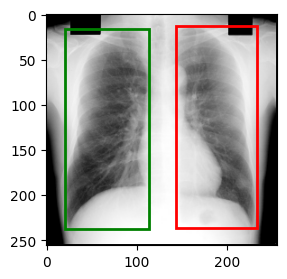

In [25]:
example_img = x_val[7]
plt.figure(figsize=(3,3))
plt.imshow(example_img)
box_1 = generated_boxes_val[7][0]
box_2 = generated_boxes_val[7][1]
show_2_boxes(box_1, box_2, plt.gca())
plt.axis('on')
plt.show()

In [14]:
#convert gen box to a numpy array
gen_box_train = np.array(generated_boxes_train)
gen_box_val = np.array(generated_boxes_val)
gen_box_test = np.array(generated_boxes_test)

In [78]:
f1 = torchmetrics.F1Score(task="binary")

f1_scores = []
i = 0

for img, mask_gt in zip(x_val, y_val):
        predictor.set_image(img)
        masks_1, score_1, logit_1 = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=gen_box_val[i][0][None,:],
            multimask_output=False)
        masks_2, score_2, logit_2 = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=gen_box_val[i][1][None,:],
            multimask_output=False)

        #combine mask 1 and mask 2
        mask_pred = masks_1 + masks_2

        mask_tensor = torch.from_numpy(mask_pred.squeeze())
        true_tensor = torch.from_numpy(mask_gt)

        f1_scores.append(f1(mask_tensor, true_tensor).item())
        i += 1

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

Mean F1 score: 0.9217
Standard deviation: 0.0226


# Object Detection Model to predict Bounding Boxes

In [28]:
# TODO: Implement an object detection model to find the left and right lung bounding boxes

In [13]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, boxes):
        self.images = images
        self.boxes = boxes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).permute(2, 0, 1).float()
        box = torch.as_tensor(self.boxes[idx], dtype=torch.float32)

        labels = torch.ones((2,), dtype=torch.int64)

        image /= 255.0

        target = {}
        target["boxes"] = box
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])

        return image, target

In [29]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_resnet50_fpn(pretrained=True)
classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, classes)


train_dataset = CustomDataset(x_train, gen_box_train)
val_dataset = CustomDataset(x_val, gen_box_val)
test_dataset = CustomDataset(x_test, gen_box_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True,
 collate_fn=lambda x: tuple(zip(*x)))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True,
 collate_fn=lambda x: tuple(zip(*x)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=True,
 collate_fn=lambda x: tuple(zip(*x)))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 30
labels = torch.ones((2,), dtype=torch.int64)
model.train()
model = model.to(device)

for epoch in range(num_epochs):
    for images, targets in train_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

torch.save(model.state_dict(), "./model")

model = fasterrcnn_resnet50_fpn(pretrained=True)
classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, classes)
model.load_state_dict(torch.load("./model"))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [42]:
model.eval()
model = model.to(device)
pred_boxes_array = []
true_boxes_array = []
ious = []

with torch.no_grad():
    for images, targets in test_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Perform inference with the object detection model
        outputs = model(images)

        for output, target in zip(outputs, targets):
            pred_boxes = output["boxes"]
            true_boxes = target["boxes"]

            # Append the boxes to the arrays
            pred_boxes_array.append(pred_boxes.cpu().numpy())
            true_boxes_array.append(true_boxes.cpu().numpy())


            # Calculate IoU scores
            iou = torchvision.ops.box_iou(pred_boxes, true_boxes)
            ious.append(iou.cpu().numpy())


            # Threshold the IoU scores based on a certain threshold (e.g., 0.5)
            iou_thresholded = iou > 0.5

            # Convert IoU scores to binary labels
            y_true = iou_thresholded.view(-1).cpu().numpy()
            y_pred = torch.ones_like(iou_thresholded, dtype=torch.float32).view(-1).cpu().numpy()

            # Calculate the F1-score
            f1_value = sklearn_f1_score(y_true, y_pred)

            f1_scores.append(f1_value)
            # Append the boxes to the arrays
            pred_boxes_array.append(pred_boxes.cpu().numpy())
            true_boxes_array.append(true_boxes.cpu().numpy())

# Concatenate the lists to create NumPy arrays
pred_boxes_array = np.concatenate(pred_boxes_array, axis=0)
true_boxes_array = np.concatenate(true_boxes_array, axis=0)
ious = np.concatenate(ious, axis=0)

mean_f1 = torch.tensor(f1_scores).mean().item()
std_f1 = torch.tensor(f1_scores).std().item()

print("IoU performance:")
print(f"  Average IoU: {ious.mean().item():.4f}")
print(f"  Maximum IoU: {ious.max().item():.4f}")
print(f"  Minimum IoU: {ious.min().item():.4f}")
print(f"  Standard deviation IoU: {np.std(ious):.4f}")


print(f"Mean F1-score: {mean_f1:.4f}")
print(f"Standard deviation F1-score: {std_f1:.4f}")



IoU performance:
  Average IoU: 0.4749
  Maximum IoU: 0.9949
  Minimum IoU: 0.0000
  Standard deviation IoU: 0.4757
Mean F1-score: 0.6660
Standard deviation F1-score: 0.0105


In [66]:
pred_box_model_init = pred_boxes_array.reshape(-1, 2, 4)
pred_box_model = pred_box_model[::2]

In [1]:
import torchmetrics
f1 = torchmetrics.F1Score(task="binary")

f1_scores = []
i = 0

for img, mask_gt in zip(x_test, y_test):
        print(i)
        predictor.set_image(img)
        masks_1, score_1, logit_1 = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=pred_box_model[i][0][None,:],
            multimask_output=False)
        masks_2, score_2, logit_2 = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=pred_box_model[i][1][None,:],
            multimask_output=False)

        #combine mask 1 and mask 2
        mask_pred = masks_1 + masks_2

        mask_tensor = torch.from_numpy(mask_pred.squeeze())
        true_tensor = torch.from_numpy(mask_gt)

        f1_scores.append(f1(mask_tensor, true_tensor).item())
        i += 1

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

ModuleNotFoundError: ignored

In [17]:
import torchmetrics
import numpy as np

iou_scores = []
f1_scores = []
i = 0

for img, mask_gt in zip(x_test, y_test):
    print(i)
    predictor.set_image(img)
    masks_1, score_1, logit_1 = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=pred_box_model[i][0][None, :],
        multimask_output=False)
    masks_2, score_2, logit_2 = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=pred_box_model[i][1][None, :],
        multimask_output=False)

    # Combine mask 1 and mask 2
    mask_pred = masks_1 + masks_2

    mask_tensor = torch.from_numpy(mask_pred.squeeze())
    true_tensor = torch.from_numpy(mask_gt)

    iou = torchvision.ops.box_iou(mask_tensor, true_tensor)
    iou_scores.append(iou.numpy())


    iou_scores.append(iou(mask_tensor, true_tensor).item())
    f1_scores.append(f1(mask_tensor, true_tensor).item())
    i += 1

mean_iou = np.mean(iou_scores)
std_iou = np.std(iou_scores)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("IoU performance:")
print(f"  Average IoU: {mean_iou:.4f}")
print(f"  Standard deviation IoU: {std_iou:.4f}")

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation F1 score: {std_f1:.4f}")


0


NameError: name 'pred_box_model' is not defined